# **Práctica 4: Autoencoders**

- Rubén Gil Martínez

### **Sesión 1/3: Autocodificadores para detección de anomalías**

<a class='anchor' id='dataset'></a>

## El dataset ECG5000

El [dataset ECG5000](https://www.timeseriesclassification.com/description.php?Dataset=ECG5000) es un conjunto de datos compuesto por series temporales, que contienen señales de electrocardiogramas (ECG) utilizadas principalmente para la detección de anomalías cardíacas. Originalmente el dataset contiene diferentes tipos etiquetados de anomalías: anomalía tipo R-on-T, anomalía tipo PVC (extrasístole ventricular), anomalía tipo SP (latido supernormal) y anomalía tipo UB (latido desconocido). Sin embargo, en esta práctica se utilizará una [versión simplificada del dataset ECG5000](http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv), que tiene un etiquetado binario (clase "normal" y clase "anómala"), que resulta más adecuado para el problema de detección de anomalías que se pretende abordar aquí.

### Características del dataset ECG5000 con etiquetado binario
- **Origen**: Derivado de la base de datos de ECG de BIDMC (Beth Israel Deaconess Medical Center).
- **Cantidad de muestras**: 5000 registros de ECG.
- **Longitud de cada serie temporal**: 140 instantes temporales.
- **Etiquetas**: (la última columna de cada registro es la etiqueta, y las 140 restantes son la señal ECG)
  - Clase 1: "normal" (se considerará conocida durante el aprendizaje)
  - Clase 0: "anómala" (se considerará desconocida durante el aprendizaje)

<div style="display:flex; justify-content:space-around; align-items:center; padding:5px solid #333333;">
    <img src="../P4/imgs/dataset_ECG5000.png" style="height:500px; width:auto;">
</div>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

**E1:** Descargue el [dataset ECG5000 simplificado](http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv), lea el CSV y genere las variables de trabajo: registros ECGs normales y anómalos por separado, así como las correspondientes etiquetas de cada uno de ellos (reetiquete clase 1 -> normal, clase 0 -> anómalo). Particione el conjunto de entrenamiento (70% de los ECGs normales) y el conjunto de test (30% restante de los ECGs normales, más todos del ECGs anómalos).

In [3]:
data = pd.read_csv('ecg.csv', sep=',', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
# Separamos los datos en dos grupos: ECG normales y anómalos
ECG_normales = data.where(data[140] == 1).dropna()
ECG_anomalos = data.where(data[140] == 0).dropna()

# Modificamos las etiquetas
ECG_normales[140] = 'normal'
ECG_anomalos[140] = 'anómalo'

Realizamos la partición del dataset en el conjunto de entrenamiento (70% de los ECGs normales) y el conjunto de test (30% restante de los ECGs normales, más todos del ECGs anómalos)

In [5]:
# Partición de los ECG normales, 70% para entrenamiento y 30% para test
X_train, X_test, y_train, y_test = train_test_split(ECG_normales.iloc[:, :-1], ECG_normales.iloc[:, -1], test_size=0.3, random_state=2025)

# Añadimos todos los ECG anómalos al conjunto de test
X_test = pd.concat([X_test, ECG_anomalos.iloc[:, :-1]])
y_test = pd.concat([y_test, ECG_anomalos.iloc[:, -1]])

In [6]:
print("Tamaño conjunto de test:", X_test.shape, y_test.shape)
print("Tamaño conjunto de entrenamiento:", X_train.shape, y_train.shape)

Tamaño conjunto de test: (2955, 140) (2955,)
Tamaño conjunto de entrenamiento: (2043, 140) (2043,)


**E2:** Siguiendo la guía indicada en el apartado que introduce los [*autoencoders* totalmente conectados](#autoencoder):
- Diseñe la pirámide de codificación-decodificación totalmente conectada, de 3 niveles de profundidad (2 niveles de profundidad adicionales al espacio latente). Utilice para ello secuencias de capas densas decrecientes-crecientes en potencias de 2, y con activación ReLU (salvo en el espacio latente).
- Entrene el modelo empleando optimizador Adam y el error absoluto medio o MAE (Mean Absolute Error) como función de pérdida. Es imprescindible implementar la parada anticipada para evitar el sobreajuste.
- De forma similar a la figura del apartado de [*autoencoders* totalmente conectados](#autoencoder), represente ejemplos de ECGs del conjunto de entrenamiento, con sus correspondientes codificaciones y reconstrucciones para diferentes dimensiones (potencia de 2) del espacio latente.

In [7]:
import matplotlib.pyplot as plt
from tensorflow import keras

### **ARQUITECTURA DEL MODELO AUTOENCODER**

In [8]:
def build_autoencoder_diff_latent_dims(latent_dim):
    # PARÁMETROS ARQUITECTURA:
    INPUT_SHAPE = X_train.iloc[0, :].shape
    INPUT_DIM = X_train.shape[1]
    DIM_1 = 64
    DIM_2 = 32
    ACTIVATION = 'relu'

    # ENCODER:

    input_layer = keras.layers.Input(shape=INPUT_SHAPE)
    x = keras.layers.Dense(DIM_1, activation=ACTIVATION)(input_layer)
    x = keras.layers.Dense(DIM_2, activation=ACTIVATION)(x)
    encoded_z = keras.layers.Dense(latent_dim)(x)

    encoder = keras.Model(input_layer, encoded_z)

    # DECODER:
    decoder_input = keras.layers.Input(shape=(latent_dim,))
    x = keras.layers.Dense(DIM_2, activation=ACTIVATION)(decoder_input)
    x = keras.layers.Dense(DIM_1, activation=ACTIVATION)(x)
    reconstructed = keras.layers.Dense(INPUT_DIM)(x)

    decoder = keras.Model(decoder_input, reconstructed)

    # AUTOENCODER COMPLETO:
    autoencoder_output = decoder(encoder(input_layer))
    autoencoder = keras.Model(input_layer, autoencoder_output)

    return autoencoder, encoder, decoder

### **ENTRENAMIENTO DEL MODELO**

In [9]:
# Configuramos hiperparámetros de entrenamiento
BATCH_SIZE = 64        # Tamaño del lote
EPOCHS = 200           # Número de épocas de entrenamiento
LEARNING_RATE = 0.001   # Tasa de aprendizaje inicial ya que usamos ADAM, un optimizador adaptativo
MIN_DELTA = 1e-4       # Cambio mínimo para considerar mejoría
PATIENCE = 20          # Épocas de espera sin mejora antes de detener entrenamiento

# Early Stopping - Para detener el entrenamiento cuando no haya más mejora en la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [10]:
# Obtenmeos un conjunto de validación para gestionar el overfitting, tener en cuenta que durante el entrenamiento
# solo nos fijamos en los datos, no son necesarias las etiquetas pero las introducimos en el split para que no se mezclen
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2025)

In [11]:
print(X_train.iloc[0, :].shape)

(140,)


**Vamos a construir varios modelos autoencoders donde cada uno tendrá una dimensión diferente en el espacio latente.**
Tener en cuenta que:
- Cuanto mayor sea la dimensión se produce una menor reducción de la dimesionalidad y una menor codificación pero será más fácil reconstruir la serie temporal.
- Cuanto menor sea la dimensión conseguimos realizar una mayor compresión de la información de la serie temporal pero, por otro lado, la tarea de reconstrucción a partir de ese espacio latente será de mayor dificultad.

In [12]:
tf.config.run_functions_eagerly(True)  # Habilitar ejecución inmediata


Entrenando autoencoder con espacio latente de dimensión: 16
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.6203

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.6179 - val_loss: 0.3935
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.3515 - val_loss: 0.2766
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.2575 - val_loss: 0.2186
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2075 - val_loss: 0.1907
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1798 - val_loss: 0.1754
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.1674 - val_loss: 0.1661
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1594 - val_loss: 0.1574
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.1493 - val_loss: 0.1497
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.1433 - val_loss: 0.1428
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1376 - val_loss: 0.1392
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1330 - val_loss: 0.1357
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 

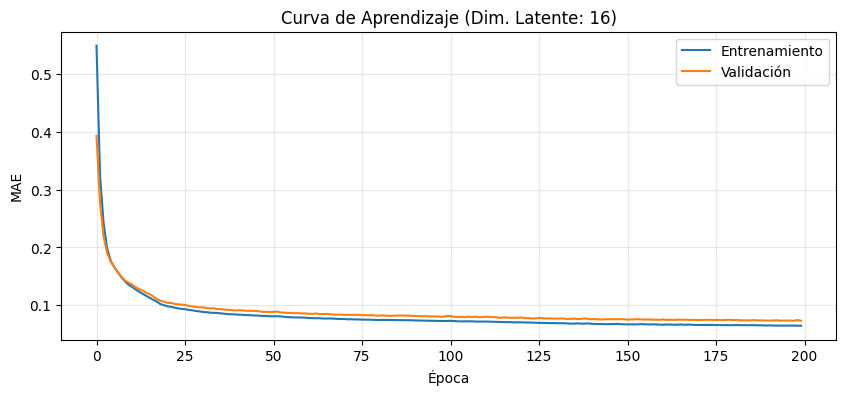


Entrenando autoencoder con espacio latente de dimensión: 8
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.6187 - val_loss: 0.3880
Epoch 2/200


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.3418 - val_loss: 0.2511
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.2245 - val_loss: 0.1920
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.1843 - val_loss: 0.1784
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.1735 - val_loss: 0.1701
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.1650 - val_loss: 0.1597
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.1573 - val_loss: 0.1531
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.1485 - val_loss: 0.1483
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1447 - val_loss: 0.1457
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.1406 - val_loss: 0.1398
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.1343 - val_loss: 0.1367
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.1273 - val_loss: 0.1321
Epoch 13/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0

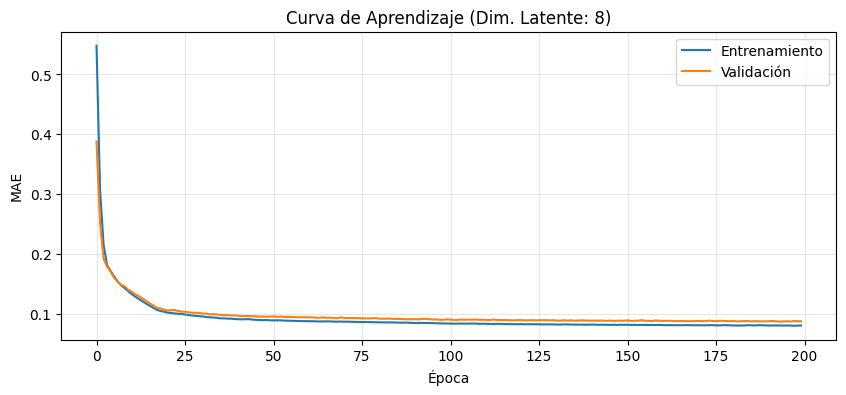


Entrenando autoencoder con espacio latente de dimensión: 4
Epoch 1/200
 1/29 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.6672

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.6060 - val_loss: 0.4109
Epoch 2/200


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.3660 - val_loss: 0.2796
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.2497 - val_loss: 0.2224
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.2049 - val_loss: 0.1894
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.1822 - val_loss: 0.1773
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1730 - val_loss: 0.1691
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1648 - val_loss: 0.1618
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.1573 - val_loss: 0.1579
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1536 - val_loss: 0.1556
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.1502 - val_loss: 0.1547
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1486 - val_loss: 0.1532
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.1486 - val_loss: 0.1525
Epoch 13/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.

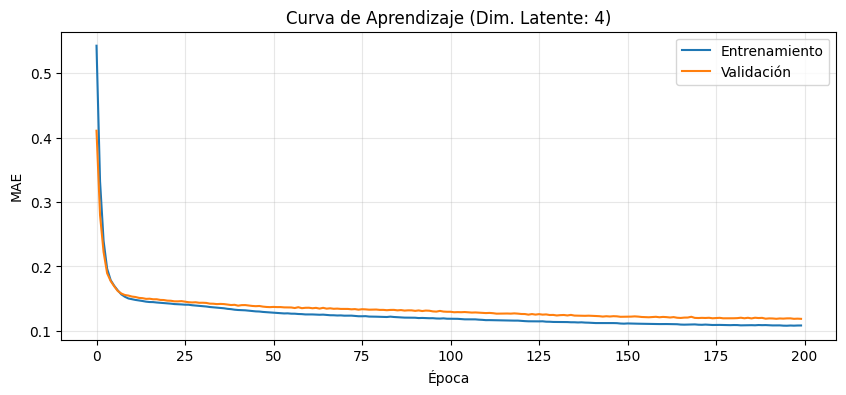


Entrenando autoencoder con espacio latente de dimensión: 2
Epoch 1/200
 1/29 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.6666

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.6045 - val_loss: 0.3824
Epoch 2/200
 1/29 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.3780

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.3363 - val_loss: 0.2732
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.2451 - val_loss: 0.2350
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.2207 - val_loss: 0.2300
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.2141 - val_loss: 0.2273
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2113 - val_loss: 0.2260
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2091 - val_loss: 0.2242
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.2132 - val_loss: 0.2214
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2115 - val_loss: 0.2188
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2051 - val_loss: 0.2156
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2062 - val_loss: 0.2135
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.2026 - val_loss: 0.2107
Epoch 13/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.

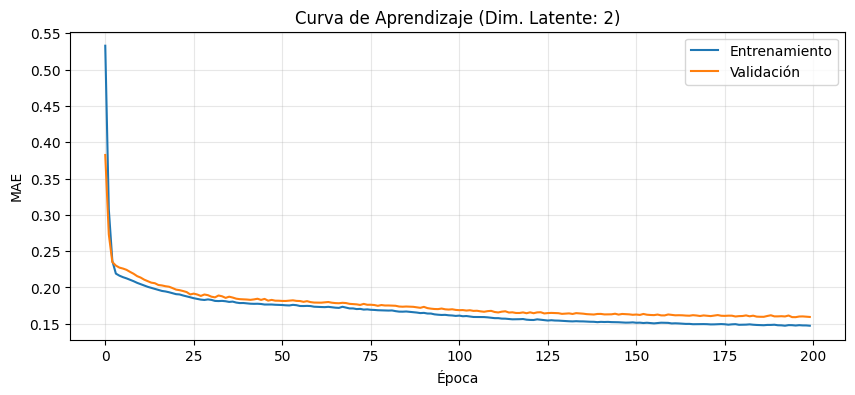

In [13]:
# Diccionario para almacenar resultados
resultados_modelos = {}
latente_dimensiones = [16, 8, 4, 2]

# Entrenar modelo para cada dimensión del espacio latente
for dim in latente_dimensiones:
    print(f"\nEntrenando autoencoder con espacio latente de dimensión: {dim}")

    # Creamos el autoencoder mediante la función de la arquitectura prediseñada
    autoencoder, encoder, decoder = build_autoencoder_diff_latent_dims(dim)

    # Compilamos con optimizador Adam y función de pérdida MAE
    OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    autoencoder.compile(optimizer=OPTIMIZER, loss='mae')

    # Entrenamos el modelo
    history = autoencoder.fit(
        X_train, X_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping],
        verbose=1)

    # Guardar resultados
    resultados_modelos[dim] = {
        'autoencoder': autoencoder,
        'encoder': encoder,
        'decoder': decoder,
        'history': history}

    # Visualizar curva de aprendizaje
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Curva de Aprendizaje (Dim. Latente: {dim})')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

**VISUALIZACIÓN DE VARIAS MUESTRAS DE ECG CON:**
- ECG REAL
- CODIFICACIÓN DEL ECG PARA CADA UNA DE LAS RESPECTIVAS DIMENSIONES DEL ESPACIO LATENTE
- RECONSTRUCCIÓN DESDE ESPACIO LATENTE DEL ECG

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


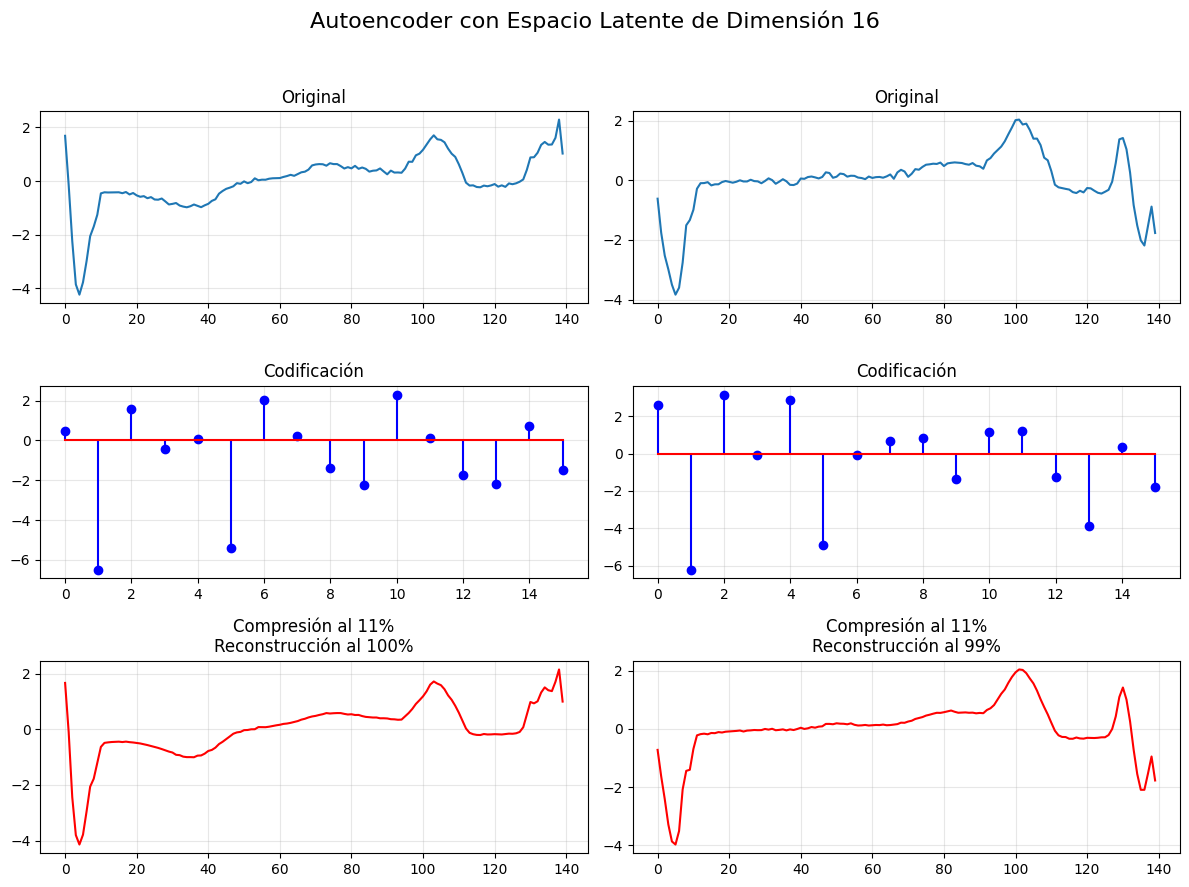

Compresión de la codificación: 11.43 %
Calidad de reconstrucción (coeficiente R2 medio): 99.26 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


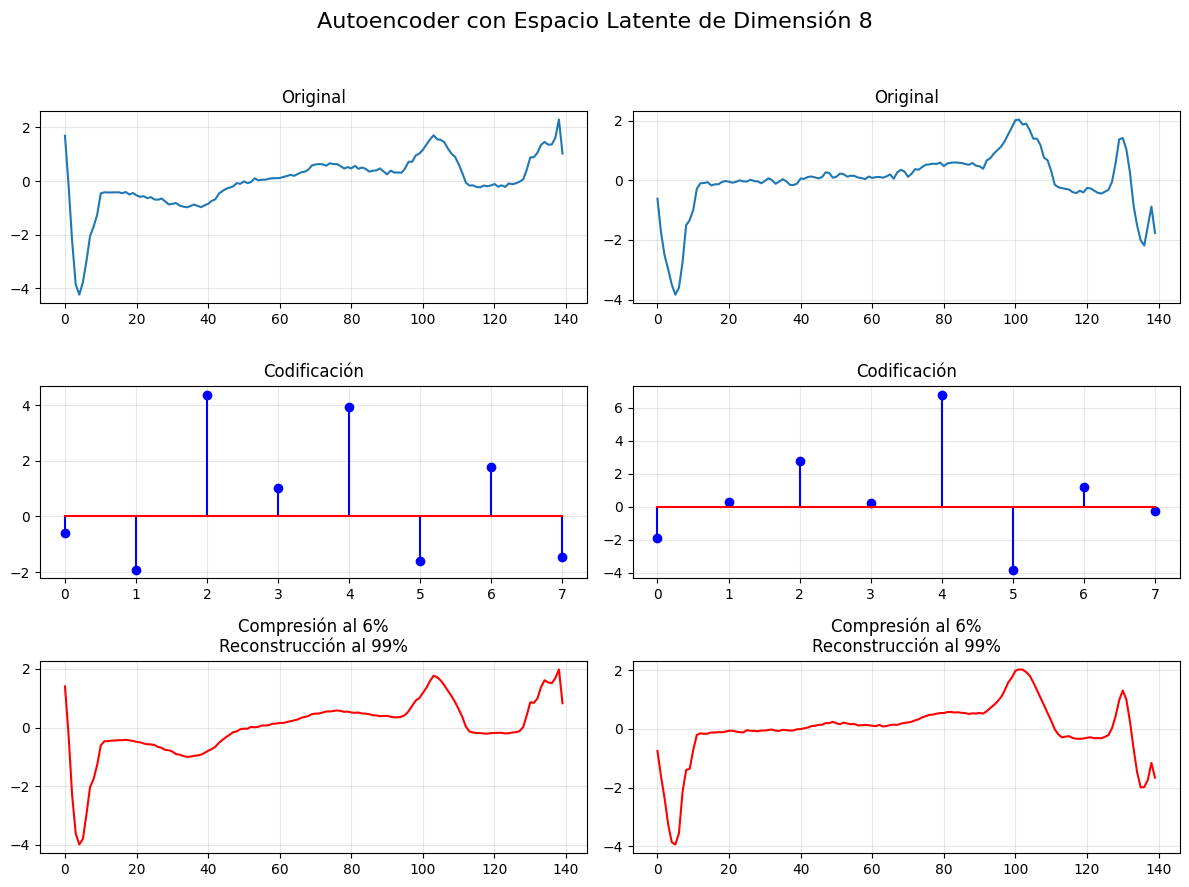

Compresión de la codificación: 5.71 %
Calidad de reconstrucción (coeficiente R2 medio): 99.08 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


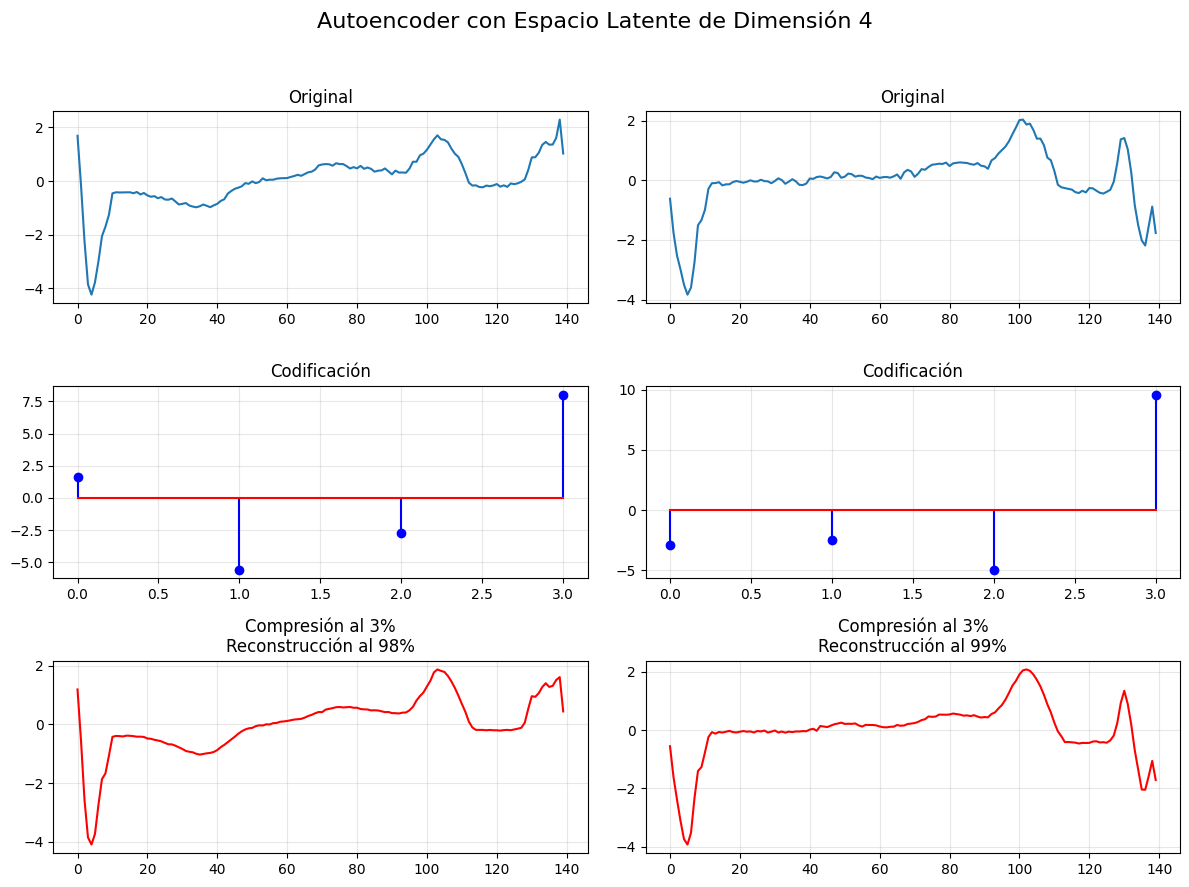

Compresión de la codificación: 2.86 %
Calidad de reconstrucción (coeficiente R2 medio): 98.50 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


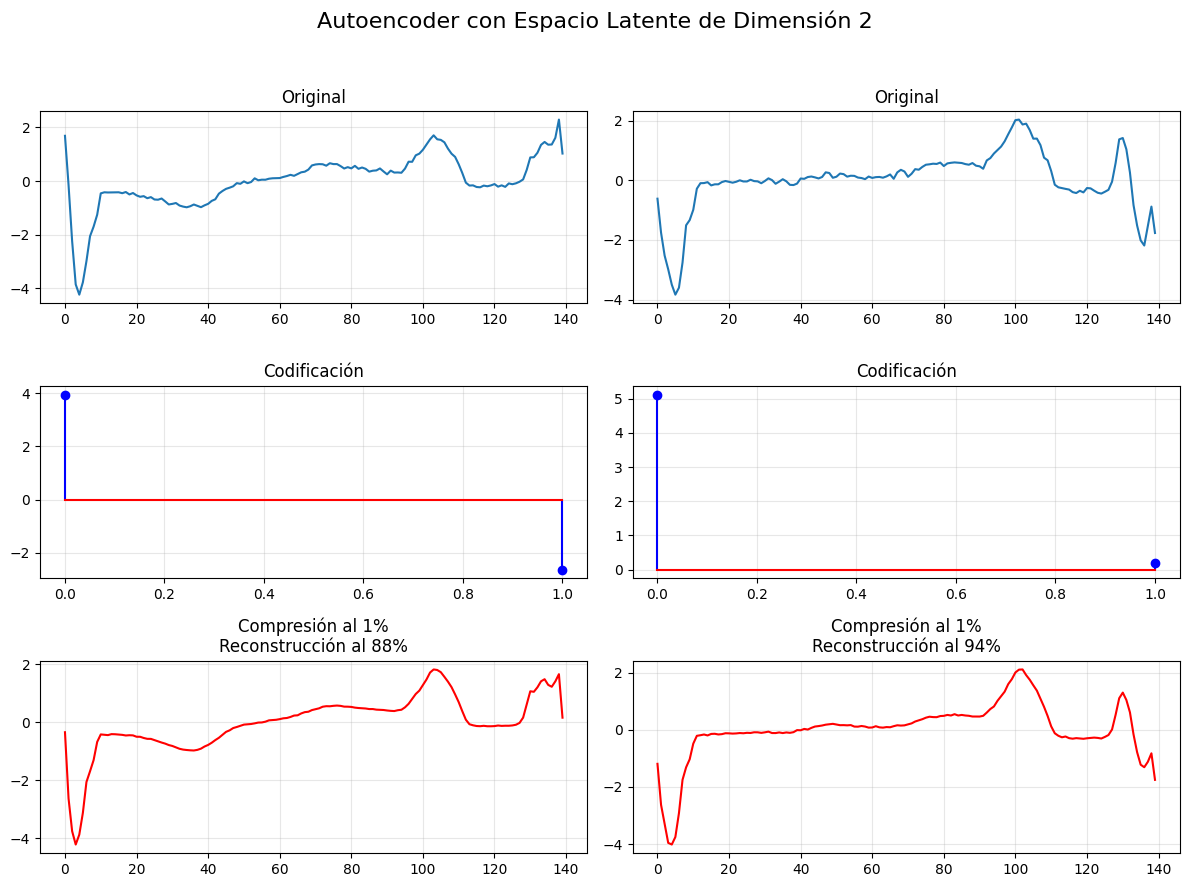

Compresión de la codificación: 1.43 %
Calidad de reconstrucción (coeficiente R2 medio): 90.97 %


In [14]:
from sklearn.metrics import r2_score

# Seleccionamos dos muestras aleatorias del conjunto de entrenamiento
np.random.seed(2025)  # Para reproducibilidad
indices_muestra = np.random.choice(len(X_train), size=2, replace=False)
muestras = X_train.iloc[indices_muestra].values


# Para cada dimensión del espacio latente realizamos:
for dim in latente_dimensiones:

    # Obtenemos los modelos entrenados
    autoencoder = resultados_modelos[dim]['autoencoder']
    encoder = resultados_modelos[dim]['encoder']
    decoder = resultados_modelos[dim]['decoder']

    # Realizamos predicciones con los respectivos modelos para así obtener las codificaciones y reconstrucciones
    codificaciones = encoder.predict(muestras)
    reconstrucciones = autoencoder.predict(muestras)

    # Calculamos las métricas
    # 1) Compresión: dimensión latente / dimensión original * 100
    tasa_compresion = dim / muestras.shape[1] * 100

    # 2) Calidad de reconstrucción / Fidelidad de la señal reconstruida (R²)
    r2_muestras = np.zeros(len(muestras))
    for i in range(len(muestras)):
        r2_muestras[i] = r2_score(muestras[i], reconstrucciones[i])
    r2 = r2_muestras.mean()

    # Crear una figura con subplots
    fig, axs = plt.subplots(3, 2, figsize=(12, 9))
    fig.suptitle(f'Autoencoder con Espacio Latente de Dimensión {dim}', fontsize=16)

    # Para cada muestra
    for i in range(2):
        # Original
        axs[0, i].plot(muestras[i])
        axs[0, i].set_title('Original')
        axs[0, i].grid(True, alpha=0.3)

        # Codificación
        axs[1, i].stem(codificaciones[i], linefmt='b-', markerfmt='bo', basefmt='r-')
        axs[1, i].set_title('Codificación')
        axs[1, i].grid(True, alpha=0.3)

        # Reconstrucción
        axs[2, i].plot(reconstrucciones[i], 'r')
        axs[2, i].set_title(f'Compresión al {tasa_compresion:.0f}%\nReconstrucción al {r2_muestras[i]*100:.0f}%')
        axs[2, i].grid(True, alpha=0.3)

    # Ajustar espaciado
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Mostrar métricas generales
    print(f"Compresión de la codificación: {tasa_compresion:.2f} %")
    print(f"Calidad de reconstrucción (coeficiente R2 medio): {r2*100:.2f} %")

**Se puede observar que la calidad de la reconstrucción es bastante buena aunque la compresión sea máxima pero hay que tener en cuenta que estamos tratando con datos de entrenamiento por lo que la máquina funciona muy bien al haber tenido experiencia con estas muestras previamente.**

**Es inmensa la capacidad de reconstrucción y la capacidad de reducción de dimensionalidad manteniendo la máxima cantidad de información posible que tienen este tipo de modelos, son un método de reducción de dimensionalidad mucho más rico que PCA por ejemplo.**

 ---

**E3:** Evalúe  el modelo entrenado sobre el conjunto de test. Con el objetivo de comparar las diferencias en cuanto a la fidelidad de la reconstrucción de los ECGs normales y los anómalos:
- Represente al menos un ECG de cada tipo (ECG normal y anómalo), superpuesto en la misma gráfica con su correspondiente reconstrucción.
- Constate esta diferencia calculando los valores numéricos de MAE que se alcanzan para cada tipo de ECG.
- Represente el histograma de los errores MAE de reconstrucción del conjunto de test, y compárelo con el histograma del entrenamiento (se recomienda representar ambos histogramas en la misma gráfica).

### **REPRESENTACIÓN DE LOS ECGS NORMAL Y ANÓMALO CON SUS RESPECTIVAS RECONSTRUCCIONES**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


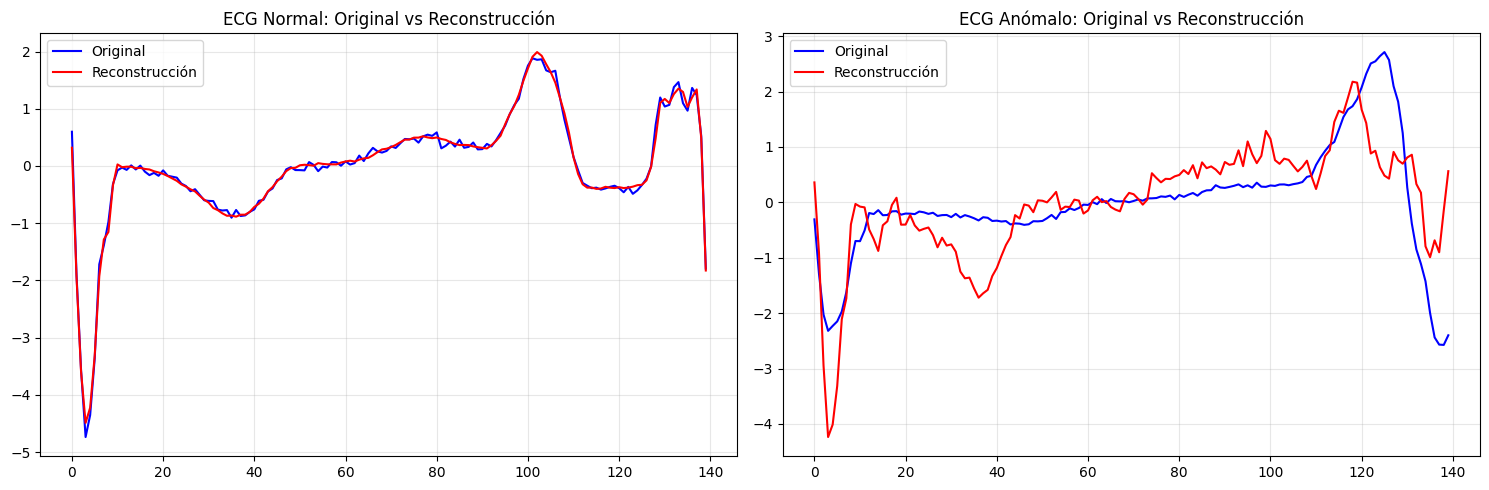

In [15]:
# Seleccionamos uno de los modelos entrenados, en este caso el de dimensión latente 16
latent_dim = 16
autoencoder_16 = resultados_modelos[latent_dim]['autoencoder']

# Separamos X_test en normales y anómalos
X_test_normal = X_test[y_test == 'normal']
X_test_anomalo = X_test[y_test == 'anómalo']

# Seleccionamos un ejemplo de cada tipo
np.random.seed(2025)  # Para reproducibilidad
indice_normal = np.random.randint(0, len(X_test_normal))  # Índice aleatorio para ECG normal
indice_anomalo = np.random.randint(0, len(X_test_anomalo))  # Índice aleatorio para ECG anómalo
ecg_normal = X_test_normal.iloc[indice_normal].values
ecg_anomalo = X_test_anomalo.iloc[indice_anomalo].values

# Obtenemos las reconstrucciones mediante la predicción del autoencoder
reconstruccion_normal = autoencoder_16.predict(ecg_normal.reshape(1, -1)).flatten()
reconstruccion_anomalo = autoencoder_16.predict(ecg_anomalo.reshape(1, -1)).flatten()

# Visualizamos
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ECG Normal
ax[0].plot(ecg_normal, 'b-', label='Original')
ax[0].plot(reconstruccion_normal, 'r-', label='Reconstrucción')
ax[0].set_title('ECG Normal: Original vs Reconstrucción')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# ECG Anómalo
ax[1].plot(ecg_anomalo, 'b-', label='Original')
ax[1].plot(reconstruccion_anomalo, 'r-', label='Reconstrucción')
ax[1].set_title('ECG Anómalo: Original vs Reconstrucción')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **CÁLCULO DE LA MÉTRICA MAE QUE SE ALCANZA EN LA RECONSTRUCCIÓN PARA CADA TIPO DE ECG: NORMAL Y ANÓMALO DEL CONJUNTO DE TEST**

In [16]:
from sklearn.metrics import mean_absolute_error


# Calcular MAE para todos los ECGs normales
X_test_normal_array = X_test_normal.values
reconstruccion_normal_array = autoencoder_16.predict(X_test_normal_array)
mae_normales = []

for i in range(len(X_test_normal_array)):
    mae = mean_absolute_error(X_test_normal_array[i], reconstruccion_normal_array[i])
    mae_normales.append(mae)

mae_promedio_normales = np.mean(mae_normales)


# Calcular MAE para todos los ECGs anómalos
X_test_anomalo_array = X_test_anomalo.values
reconstruccion_anomalo_array = autoencoder_16.predict(X_test_anomalo_array)
mae_anomalos = []

for i in range(len(X_test_anomalo_array)):
    mae = mean_absolute_error(X_test_anomalo_array[i], reconstruccion_anomalo_array[i])
    mae_anomalos.append(mae)

mae_promedio_anomalos = np.mean(mae_anomalos)

print(f"MAE promedio para ECGs normales: {mae_promedio_normales:.4f}")
print(f"MAE promedio para ECGs anómalos: {mae_promedio_anomalos:.4f}")
print(f"Diferencia (Anómalos - Normales): {mae_promedio_anomalos - mae_promedio_normales:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
15/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MAE promedio para ECGs normales: 0.0697
MAE promedio para ECGs anómalos: 0.3404
Diferencia (Anómalos - Normales): 0.2707


**Ese aumento de la métrica MAE en la reconstrucción de ECGs anómalos será un factor clave para indentificar anomalías en ECGs no antes vistos y que tengan comportamientos inusuales, por tanto, puede ser una buena idea definir un cierto umbral de métrica MSE en la reconstrucción para poder realizar una clasificación robusta entre las series temporales de ECGs normales y ECGs anómalos.**

**Este umbral va a ser posible fijarlo ya que cuando el autoencoder se enfrente a un ECG normal no visto antes será capaz de reconstruirlo mediante un MAE considerablemente pequeño con respecto al MAE dado al intentar reconstruir un ECG anónmalo, eso hará que la distribución de los ECGs con respecto a su pérdida en reconstrucción sea separable linealmente pudiendo conseguir así una clasificación fiable de estos.**


### **VISUALIZACIÓN DE LA DISTRIBUCIÓN DE LOS ERRORES MAE EN RECONSTRUCCIÓN**
- **Histograma de los errores MAE de reconstrucción del conjunto de test y del conjunto de entrenamiento**

In [17]:
# Calculamos MAE para todo el conjunto de entrenamiento
X_train_array = X_train.values
reconstruccion_train = autoencoder_16.predict(X_train_array)
mae_train = []

for i in range(len(X_train_array)):
    mae = mean_absolute_error(X_train_array[i], reconstruccion_train[i])
    mae_train.append(mae)

# Calcular MAE para todo el conjunto de test
X_test_array = X_test.values
reconstruccion_test = autoencoder_16.predict(X_test_array)
mae_test = []

for i in range(len(X_test_array)):
    mae = mean_absolute_error(X_test_array[i], reconstruccion_test[i])
    mae_test.append(mae)

15/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


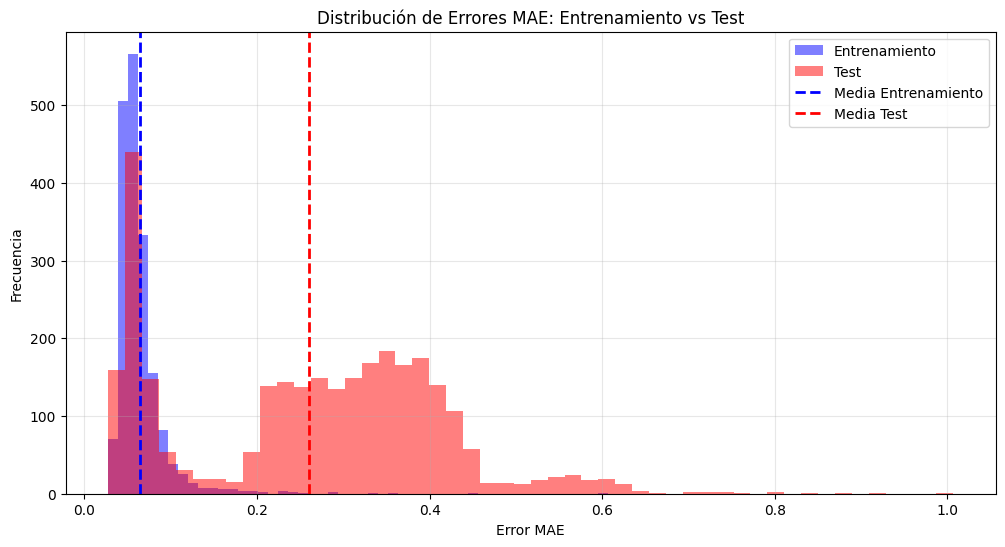

MAE promedio en Entrenamiento: 0.0638
MAE promedio en Test: 0.2601
Desviación estándar MAE en Entrenamiento: 0.0313
Desviación estándar MAE en Test: 0.1519


In [18]:
plt.figure(figsize=(12, 6))
# Histograma del conjunto de entrenamiento y test
plt.hist(mae_train, bins=50, alpha=0.5, label='Entrenamiento', color='blue')
plt.hist(mae_test, bins=50, alpha=0.5, label='Test', color='red')

# Añadimos líneas verticales para visualizar los valores medios
plt.axvline(np.mean(mae_train), color='blue', linestyle='dashed', linewidth=2, label='Media Entrenamiento')
plt.axvline(np.mean(mae_test), color='red', linestyle='dashed', linewidth=2, label='Media Test')

plt.title('Distribución de Errores MAE: Entrenamiento vs Test')
plt.xlabel('Error MAE')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Mostrar estadísticas adicionales
print(f"MAE promedio en Entrenamiento: {np.mean(mae_train):.4f}")
print(f"MAE promedio en Test: {np.mean(mae_test):.4f}")
print(f"Desviación estándar MAE en Entrenamiento: {np.std(mae_train):.4f}")
print(f"Desviación estándar MAE en Test: {np.std(mae_test):.4f}")


- **Histograma de los errores MAE de reconstrucción del conjunto de test separando por tipo de ECG (Normal y Anómalo):**

In [19]:
umbral = np.percentile(mae_normales, 95) # Umbral del 95% de clasificación correcta de ECGs normales

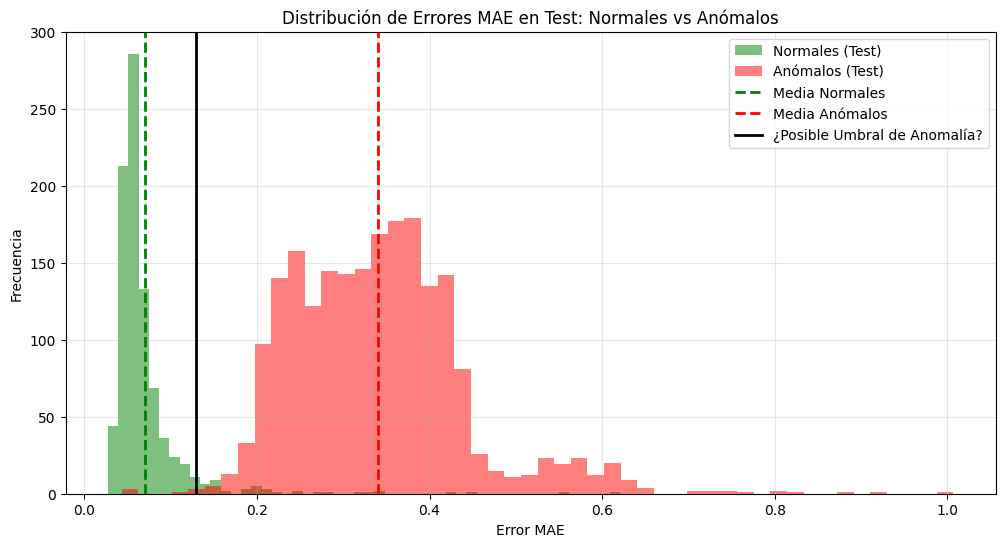

In [20]:
plt.figure(figsize=(12, 6))

# Histograma de ECGs normales en test
plt.hist(mae_normales, bins=50, alpha=0.5, label='Normales (Test)', color='green')

# Histograma de ECGs anómalos en test
plt.hist(mae_anomalos, bins=50, alpha=0.5, label='Anómalos (Test)', color='red')

# Añadir líneas verticales para los valores medios
plt.axvline(mae_promedio_normales, color='green', linestyle='--', linewidth=2, label='Media Normales')
plt.axvline(mae_promedio_anomalos, color='red', linestyle='--', linewidth=2, label='Media Anómalos')
plt.axvline(umbral, color='black', linestyle='-', linewidth=2, label='¿Posible Umbral de Anomalía?')

plt.title('Distribución de Errores MAE en Test: Normales vs Anómalos')
plt.xlabel('Error MAE')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

**E4:** En base a los resultados anteriores, razone si se observa presumible separabilidad por umbral entre los ECGs normales y anómalas del conjunto de test, y estime un posible valor umbral (un cierto percentil de los errores MAE de reconstrucción del conjunto de test) que permita la separación (detección) de los ECGs anómalos. Según este criterio, un registro del conjunto de test se considerará anómalo si su MAE de reconstrucción supera dicho umbral. Aplique el umbral de detección, y clasifique los registros ECG del conjunto de test en "normales" o "anómalos"

---

**Se observa claramente separación por umbral en el conjunto de test entre ECGs normales y anómalos, se puede ver claramente en la gráfica de arriba.**

 **Para la estimación de un posible umbral de clasificación de los ECGs podemos plantear utilizar ciertos métodos que buscan el punto de máxima separabilidad entre distribuciones, he planteado utilizar el `Método de Otsu` visto en Proc.Imagen pero no termina de encontrar el punto óptimo de separación.**

 **Por tanto, he definido un bucle con evaluación de las métricas de clasificación de los distintos ECGs y nos vamos a quedar con el valor de MAE del conjunto de test que maximice el valor de dichas métricas.**

Umbral óptimo: 0.1570
Métrica de exactitud con el umbral óptimo: 0.9875
Sensibilidad (recall) con el umbral óptimo: 0.9947


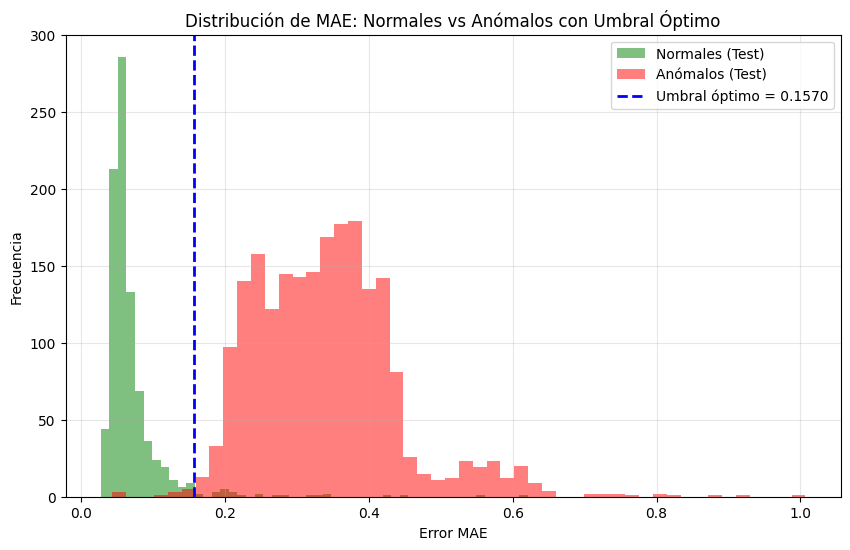

In [21]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Combinamos los MAE y las etiquetas
mae_ECGs_test = np.concatenate([mae_normales, mae_anomalos])
labels = np.concatenate([np.ones(len(mae_normales)), np.zeros(len(mae_anomalos))])  # 0: Anómalo, 1: Normal

# Ordenamos los valores MAE para iterar sobre posibles umbrales
sorted_mae = np.sort(mae_ECGs_test)

# Inicializar variables para almacenar el mejor umbral y su precisión
best_threshold = None
best_accuracy = 0

# Iterar sobre los posibles umbrales
for threshold in sorted_mae:
    # Clasificar según el umbral
    predictions = (mae_ECGs_test < threshold).astype(int)
    # Si el MAE es mayor que el umbral, se considera anómalo False (0), de lo contrario normal True (1)

    # Calculo de métricas
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)

    # Actualizar el mejor umbral si mejora la precisión
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
        recall_best = recall

print(f"Umbral óptimo: {best_threshold:.4f}")
print(f"Métrica de exactitud con el umbral óptimo: {best_accuracy:.4f}")
print(f"Sensibilidad (recall) con el umbral óptimo: {recall_best:.4f}")

# Histograma de MAE con el umbral óptimo
plt.figure(figsize=(10, 6))
plt.hist(mae_normales, bins=50, alpha=0.5, label='Normales (Test)', color='green')
plt.hist(mae_anomalos, bins=50, alpha=0.5, label='Anómalos (Test)', color='red')
plt.axvline(best_threshold, color='blue', linestyle='dashed', linewidth=2, label=f'Umbral óptimo = {best_threshold:.4f}')
plt.title('Distribución de MAE: Normales vs Anómalos con Umbral Óptimo')
plt.xlabel('Error MAE')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**MATRIZ DE CONFUSIÓN Y MÉTRICAS PARA EL AUTOENCODER CON DIMENSIÓN 16 DEL ESPACIO LATENTE**

In [22]:
print(y_test.value_counts())
y_test = y_test.replace({'normal': 1, 'anómalo': 0})  # Convertir etiquetas a numéricas
print(y_test.value_counts())

140
anómalo    2079
normal      876
Name: count, dtype: int64
140
1    2079
0     876
Name: count, dtype: int64


<ipython-input-22-fa050c0723b5>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace({'normal': 0, 'anómalo': 1})  # Convertir etiquetas a numéricas


15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       876
     Anómalo       0.99      0.99      0.99      2079

    accuracy                           0.99      2955
   macro avg       0.99      0.98      0.98      2955
weighted avg       0.99      0.99      0.99      2955



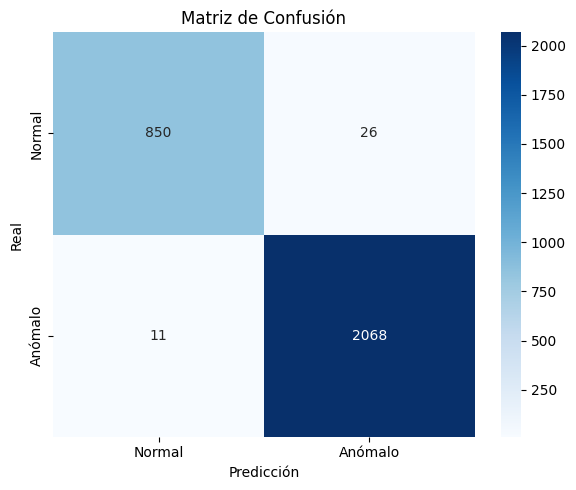

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predicciones para comprobar el correcto funcionamiento
mae_test = tf.abs(X_test - autoencoder_16.predict(X_test)).numpy().mean(axis = 1)
y_pred = (mae_test < best_threshold).astype(int)  # Si supera el umbral entonces anómalo (0/False)

# Reporte de métricas
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["Anómalo", "Normal"]))

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Etiquetas
labels = ["Anómalo", "Normal"]

# Gráfico
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

**Los resultados obtenidos en la clasificación muestran un rendimiento óptimo en términos de precisión, recall y f1-score para ambos tipos de ECGs. Esto concuerda con la visualización de los histogramas de errores, donde pudimos observar esa clara separabilidad entre las distribuciones.**

**E5:** Si se desean unas prestaciones de sensibilidad mínima de detección de ECGs anómalos del 99%, calcule la [especificidad esperable](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SpecificityAtSensitivity) (el valor objetivo estaría cercano o superando el 95%). Experimente con el aumento o disminución en potencias de 2 del número de neuronas de la pirámide del *autoencoder* o el umbral de detección. Experimente también el beneficio que aporta la [estandarización inicial](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) de los registros ECG.

**Fijamos una detección mínima de ECGs anómalos del 99%, sería la `Sensibilidad o Recall`, partiendo de esta premisa calculemos la `Especificidad esperable`, esta segunda métrica marca la capacidad del modelo de predecir que un ECG es normal cuando realmente lo es.**

In [24]:
def especificidad_esperable(autoencoder, X_test, y_test):
    # Calcular errores de reconstrucción (MAE)
    reconstrucciones = autoencoder.predict(X_test)
    errores = np.mean(np.abs(X_test - reconstrucciones), axis=1)

    # Inicializar la métrica de Keras
    especificidad_metric = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.99)

    # Actualizar la métrica con los errores y etiquetas
    especificidad_metric.update_state(y_test, errores)

    especificidad = especificidad_metric.result().numpy()
    print(f"Especificidad esperable con sensibilidad >= 99%: {especificidad:.4f}")


especificidad_esperable(autoencoder_16, X_test.values, y_test)

14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Especificidad esperable con sensibilidad >= 99%: 0.9715


Podemos observar que el modelo obtiene una métrica de `Especificidad Esperada` muy buena teniendo en cuenta que fijamos la tasa de detección de anomalías cardiacas al 99%. En este tipo de caso de estudio en cardiología es también importante evitar las falsas alarmas ya que pueden llevar al cardiólogo a dar un diagnóstico erróneo.

Vamos a modificar ahora la arquitectura del encoder añadiendo más capacidad con el aumento del número de neuronas, parámetros y capas, además, vamos a realizar una **Estandarización inicial** de los registros mediante **StandardScaler()**  para ver si conseguimos mejorar, aún más el rendimiento del modelo en su tarea de clasificación.

**Estandarización de los datos**

La estadarización inicial de los registros nos aporta varios beneficios como:
- Convergencia más rápida del entrenamiento
- Evitar los problemas de desvanecimiento o explosión de gradiente debido a inestabilidad numérica

In [47]:
from sklearn.preprocessing import StandardScaler

# Estandarización inicial de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, :-1])
data_scaled = pd.DataFrame(data_scaled, columns=data.columns[:-1])
data_scaled[140] = data[140]  # Añadir la columna de etiquetas al final
data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,0.130153,-0.814568,-0.924228,-0.944124,-1.094131,-0.671668,0.124996,-0.032972,0.250098,0.696819,...,0.513326,0.605224,0.566451,0.527580,0.488543,0.517122,0.412091,0.771724,0.636166,1.0
1,-0.727546,-1.623782,-1.293513,-1.064503,-0.773906,-0.406149,0.966096,1.293489,1.028745,1.487142,...,0.332585,0.437138,0.561453,0.598203,0.631427,0.637864,0.761909,0.877865,-0.515937,1.0
2,-0.264321,-0.652846,-0.996602,-1.124003,-0.923370,-0.314664,0.724388,0.493143,0.355220,0.823413,...,0.580196,0.360933,0.310117,0.235937,0.022838,0.147356,0.518408,0.760222,0.201360,1.0
3,0.653434,-0.183049,-0.810594,-0.920385,-0.996320,-1.119819,-0.984845,0.203334,0.119189,-0.045343,...,0.199036,0.341283,0.462661,0.655519,0.821410,0.887756,0.930247,1.032647,0.228393,1.0
4,0.922244,0.536583,0.077804,-0.655161,-1.059890,-1.032988,-0.357699,0.023013,-0.289992,0.277635,...,0.767345,0.620348,0.704795,0.912718,0.977369,0.873248,0.867974,1.148099,1.504682,1.0


In [49]:
# Separamos los datos en dos grupos: ECG normales y anómalos
ECG_normales_scaled = data_scaled.where(data[140] == 1).dropna()
ECG_anomalos_scaled = data_scaled.where(data[140] == 0).dropna()

# Modificamos las etiquetas
ECG_normales_scaled[140] = 'normal'
ECG_anomalos_scaled[140] = 'anómalo'

# Partición de los ECG normales, 70% para entrenamiento y 30% para test
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(ECG_normales_scaled.iloc[:, :-1], ECG_normales_scaled.iloc[:, -1], test_size=0.3, random_state=2025)

# Añadimos todos los ECG anómalos al conjunto de test
X_test_scaled = pd.concat([X_test_scaled, ECG_anomalos_scaled.iloc[:, :-1]])
y_test = pd.concat([y_test, ECG_anomalos_scaled.iloc[:, -1]])

# Partición de X_train_scaled en entrenamiento y validación
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.1, random_state=2025)

**Creación de un autoencoder más potente -> ARQUITECTURA**

In [34]:
#PARÁMETROS ARQUITECTURA:
INPUT_SHAPE = X_train_scaled.iloc[0, :].shape
INPUT_DIM = X_train_scaled.shape[1]
DIM_1 = 128
DIM_2 = 64
ACTIVATION = 'relu'
latent_dim = 16  # Dimensión del espacio latente

# ENCODER:
input_layer = keras.layers.Input(shape=INPUT_SHAPE)
x = keras.layers.Dense(DIM_1, activation=ACTIVATION)(input_layer)
x = keras.layers.Dense(DIM_2, activation=ACTIVATION)(x)
encoded_z = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(input_layer, encoded_z)

# DECODER:
decoder_input = keras.layers.Input(shape=(latent_dim,))
x = keras.layers.Dense(DIM_2, activation=ACTIVATION)(decoder_input)
x = keras.layers.Dense(DIM_1, activation=ACTIVATION)(x)
reconstructed = keras.layers.Dense(INPUT_DIM)(x)

decoder = keras.Model(decoder_input, reconstructed)

# AUTOENCODER COMPLETO:
autoencoder_output = decoder(encoder(input_layer))
autoencoder_with_SC = keras.Model(input_layer, autoencoder_output)


**ENTRENAMIENTO Y EVALUACIÓN**

In [37]:
# Configuramos hiperparámetros de entrenamiento
BATCH_SIZE = 32        # Tamaño del lote
EPOCHS = 200          # Número de épocas de entrenamiento
LEARNING_RATE = 0.0001   # Tasa de aprendizaje inicial ya que usamos ADAM, un optimizador adaptativo
MIN_DELTA = 1e-4       # Cambio mínimo para considerar mejoría
PATIENCE = 10          # Épocas de espera sin mejora antes de detener entrenamiento

# Early Stopping - Para detener el entrenamiento cuando no haya más mejora en la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [38]:
# Compilamos con optimizador Adam y función de pérdida MAE
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
autoencoder_with_SC.compile(optimizer=OPTIMIZER, loss='mae')

# Entrenamos el modelo
history_with_SC = autoencoder_with_SC.fit(
        X_train_scaled, X_train_scaled,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(X_val_scaled, X_val_scaled),
        callbacks=[early_stopping],
        verbose=1)


Epoch 1/200
 2/58 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.3481 

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.3290 - val_loss: 0.3336
Epoch 2/200


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.3101 - val_loss: 0.3156
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.2919 - val_loss: 0.3013
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.2885 - val_loss: 0.2898
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.2751 - val_loss: 0.2806
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.2672 - val_loss: 0.2733
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.2509 - val_loss: 0.2672
Epoch 8/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.2494 - val_loss: 0.2617
Epoch 9/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.2442 - val_loss: 0.2572
Epoch 10/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.2407 - val_loss: 0.2530
Epoch 11/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.2395 - val_loss: 0.2494
Epoch 12/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.2298 - val_loss: 0.2456
Epoch 13/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.

In [50]:
y_test = y_test.replace({'normal': 1, 'anómalo': 0})  # Convertir etiquetas a numéricas


<ipython-input-50-57640898aa34>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace({'normal': 1, 'anómalo': 0})  # Convertir etiquetas a numéricas


In [51]:
print(y_test.value_counts())

140
0    2079
1     876
Name: count, dtype: int64


In [52]:
especificidad_esperable(autoencoder_with_SC, X_test_scaled, y_test)

14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Especificidad esperable con sensibilidad >= 99%: 0.0000


**No parece que de esta forma podamos conseguir mejorar el rendimiento, parece como si el escalado de los registros nos este privando de conseguir las mejoras, veamos una gráfica del entrenamiento de los modelos.**

In [53]:
print(resultados_modelos.values())

dict_values([{'autoencoder': <Functional name=functional_2, built=True>, 'encoder': <Functional name=functional, built=True>, 'decoder': <Functional name=functional_1, built=True>, 'history': <keras.src.callbacks.history.History object at 0x7f2047f924d0>}, {'autoencoder': <Functional name=functional_5, built=True>, 'encoder': <Functional name=functional_3, built=True>, 'decoder': <Functional name=functional_4, built=True>, 'history': <keras.src.callbacks.history.History object at 0x7f204727f650>}, {'autoencoder': <Functional name=functional_8, built=True>, 'encoder': <Functional name=functional_6, built=True>, 'decoder': <Functional name=functional_7, built=True>, 'history': <keras.src.callbacks.history.History object at 0x7f20400c2c10>}, {'autoencoder': <Functional name=functional_11, built=True>, 'encoder': <Functional name=functional_9, built=True>, 'decoder': <Functional name=functional_10, built=True>, 'history': <keras.src.callbacks.history.History object at 0x7f2047086350>}])


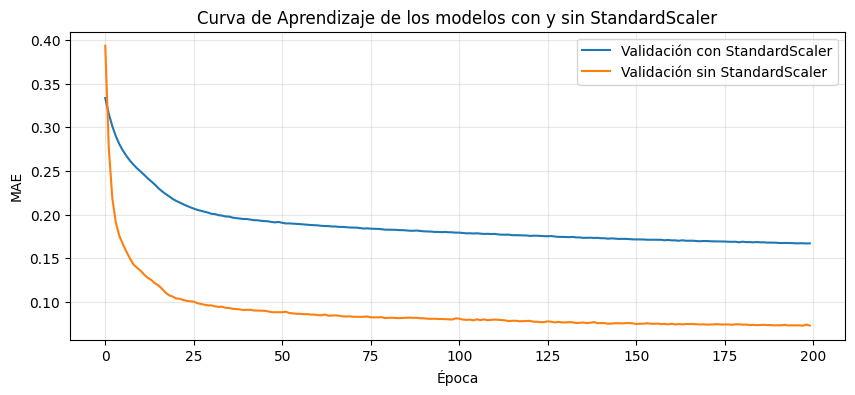

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(history_with_SC.history['val_loss'], label='Validación con StandardScaler')
plt.plot(resultados_modelos[16]['history'].history['val_loss'], label='Validación sin StandardScaler')
plt.title('Curva de Aprendizaje de los modelos con y sin StandardScaler')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Podemos observar en la gráfica de las métricas de validación que, aunque el escalado de los datos a un rango común de ciertos beneficios, en este caso perjudica al rendimiento del modelo.**

**Muy posiblemente se deba a la naturaleza secuencial que tienen las series temporales con las que estamos trabajando, esta estandarización puede hacer que se destruya la relación temporal inherente en los datos y llevar a fugas de información que hagan que el modelo no sea capaz de reconstruir los ECGs de manera adecuada.**